In [35]:
# ===== CELDA 4: PREPROCESAMIENTO DE DATOS =====
print("=== PREPROCESAMIENTO DE DATOS ===")

# Codificar la variable Type
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
print(f"Codificación de tipos: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Selección de características
features = ['type_encoded', 'air temperature [k]', 'process temperature [k]', 
           'rotational speed [rpm]', 'torque [nm]', 'tool wear [min]']

X = df[features]
y = df['machine failure']

print(f"\nBalance de clases:")
print(f"Clase 0 (Sin falla): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.2f}%)")
print(f"Clase 1 (Con falla): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.2f}%)")

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# ===== CELDA 5: BALANCEO DE CLASES CON SMOTE =====
print("=== BALANCEO DE CLASES CON SMOTE ===")

from imblearn.over_sampling import SMOTE

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nDistribución antes del balanceo: {np.bincount(y_train)}")
print(f"Distribución después del balanceo: {np.bincount(y_train_balanced)}")

# Estandarización de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("✓ Preprocesamiento con SMOTE completado")

# ===== CELDA 6: ENTRENAMIENTO DE RANDOM FOREST =====
print("=== ENTRENAMIENTO DE RANDOM FOREST ===")

# Búsqueda de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

rf_model = RandomForestClassifier(random_state=42)
cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    rf_model, param_grid_rf, cv=cv_rf, scoring='f1', 
    n_jobs=-1, verbose=1
)

print("Buscando mejores parámetros para Random Forest...")
grid_search_rf.fit(X_train_scaled, y_train_balanced)

# Mejor modelo Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

print(f"\nMejores parámetros Random Forest: {grid_search_rf.best_params_}")
print(f"Mejor score en validación: {grid_search_rf.best_score_:.4f}")

=== PREPROCESAMIENTO DE DATOS ===
Codificación de tipos: {'H': np.int64(0), 'L': np.int64(1), 'M': np.int64(2)}

Balance de clases:
Clase 0 (Sin falla): 9661 (96.61%)
Clase 1 (Con falla): 339 (3.39%)

Tamaño del conjunto de entrenamiento: (7000, 6)
Tamaño del conjunto de prueba: (3000, 6)
=== BALANCEO DE CLASES CON SMOTE ===

Distribución antes del balanceo: [6763  237]
Distribución después del balanceo: [6763 6763]
✓ Preprocesamiento con SMOTE completado
=== ENTRENAMIENTO DE RANDOM FOREST ===
Buscando mejores parámetros para Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Mejores parámetros Random Forest: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor score en validación: 0.9754



=== ENTRENAMIENTO DE SVM ===
Buscando mejores parámetros para SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros SVM: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor score en validación: 0.9469
=== EVALUACIÓN DE MODELOS ===

=== RESULTADOS Random Forest ===
Accuracy: 0.9507
Precision: 0.3678
Recall: 0.6275
F1-Score: 0.4638
ROC-AUC: 0.9644

Reporte de Clasificación - Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2898
           1       0.37      0.63      0.46       102

    accuracy                           0.95      3000
   macro avg       0.68      0.79      0.72      3000
weighted avg       0.97      0.95      0.96      3000


=== RESULTADOS SVM ===
Accuracy: 0.9210
Precision: 0.2664
Recall: 0.7549
F1-Score: 0.3939
ROC-AUC: 0.9501

Reporte de Clasificación - SVM:
              precision    recall  f1-score   support

           0       0.99      0.9

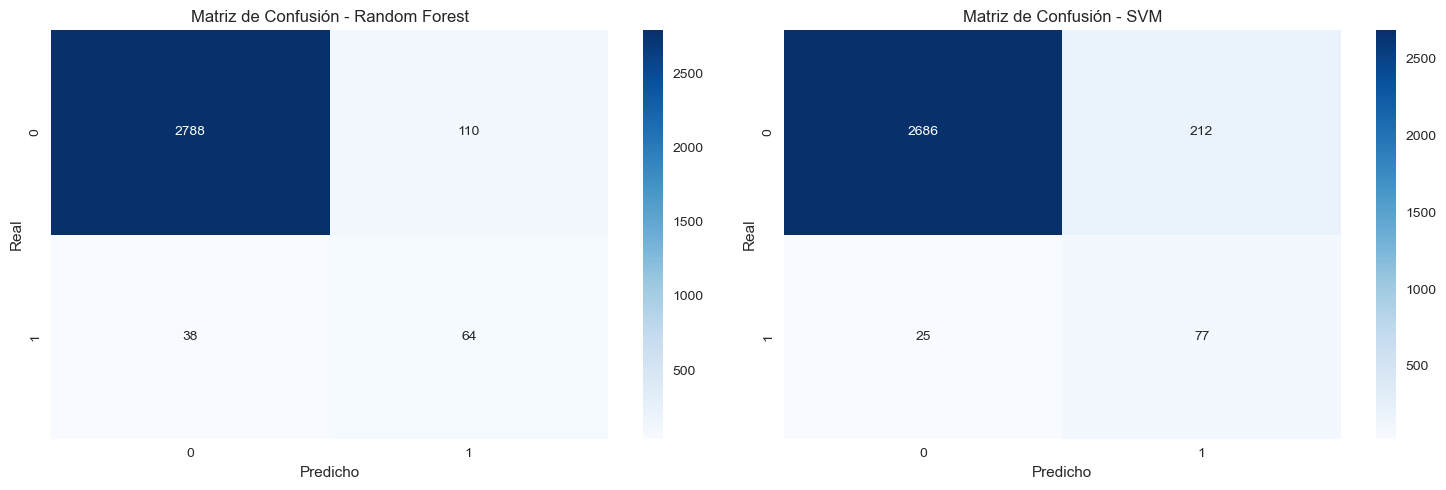

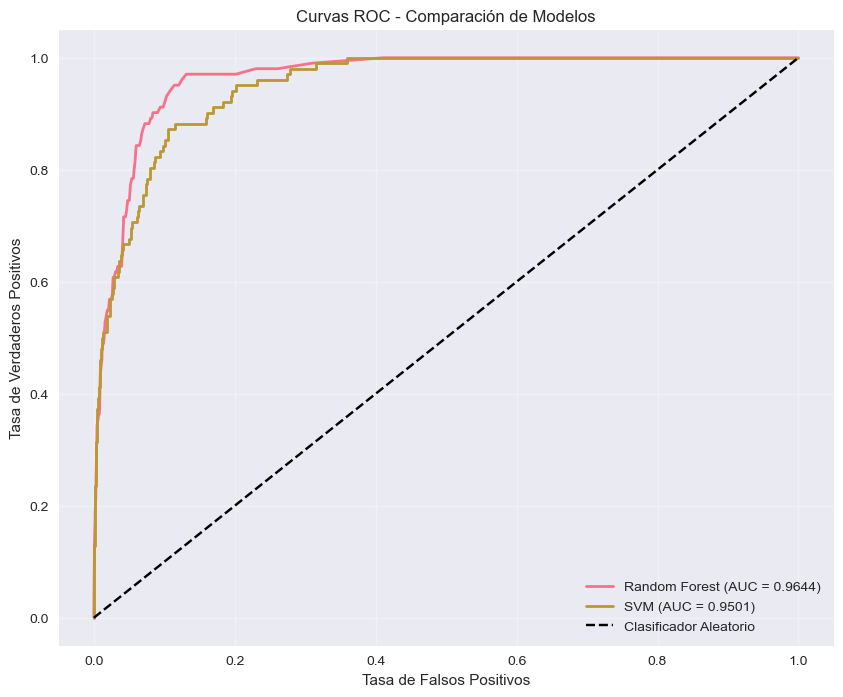

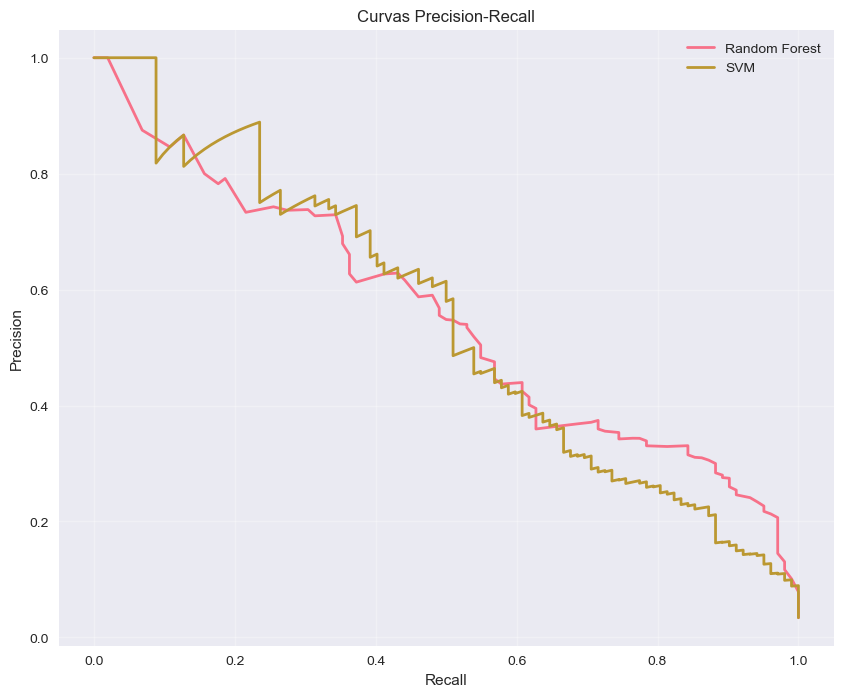

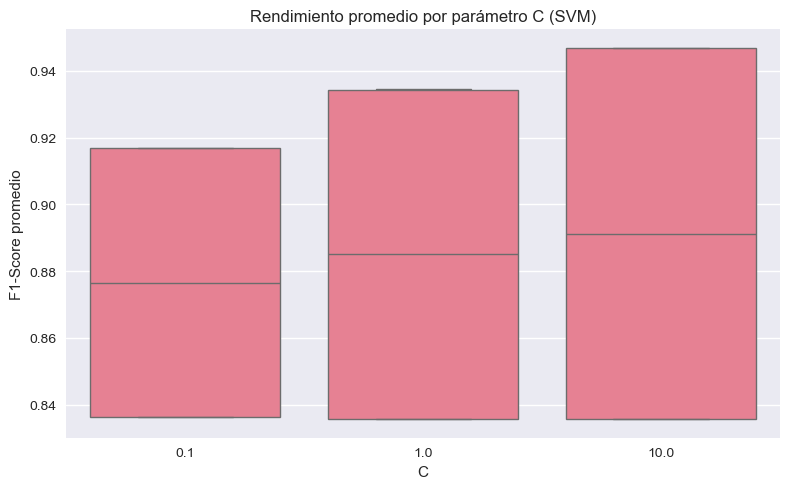

<Axes: xlabel='param_kernel', ylabel='mean_test_score'>

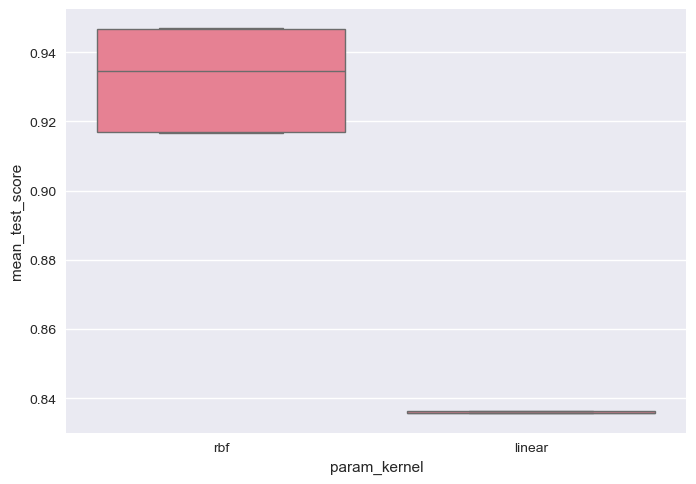

In [29]:
# ===== CELDA 7: ENTRENAMIENTO DE SVM =====
print("\n=== ENTRENAMIENTO DE SVM ===")

# Búsqueda de hiperparámetros para SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None]
}

svm_model = SVC(probability=True, random_state=42)

grid_search_svm = GridSearchCV(
    svm_model, param_grid_svm, cv=cv_rf, scoring='f1', 
    n_jobs=-1, verbose=1
)

print("Buscando mejores parámetros para SVM...")
grid_search_svm.fit(X_train_scaled, y_train_balanced)

# Mejor modelo SVM
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
y_pred_proba_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

print(f"Mejores parámetros SVM: {grid_search_svm.best_params_}")
print(f"Mejor score en validación: {grid_search_svm.best_score_:.4f}")

# ===== CELDA 8: EVALUACIÓN Y COMPARACIÓN DE MODELOS =====
def evaluate_model(model_name, y_true, y_pred, y_pred_proba):
    """Evalúa un modelo y retorna métricas"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n=== RESULTADOS {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Reporte de clasificación
    print(f"\nReporte de Clasificación - {model_name}:")
    print(classification_report(y_true, y_pred))
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Evaluar ambos modelos
print("=== EVALUACIÓN DE MODELOS ===")
results = []
results.append(evaluate_model("Random Forest", y_test, y_pred_rf, y_pred_proba_rf))
results.append(evaluate_model("SVM", y_test, y_pred_svm, y_pred_proba_svm))

# Comparación en DataFrame
results_df = pd.DataFrame(results)
print("\n=== COMPARACIÓN DE MODELOS ===")
print(results_df.round(4))
# ===== CELDA 9: VISUALIZACIÓN DE RESULTADOS =====
# 9.1 Matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Matriz de confusión Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Random Forest')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Matriz de confusión SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusión - SVM')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# 9.2 Curvas ROC
plt.figure(figsize=(10, 8))

# Curva ROC Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Curva ROC SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 9.3 Curvas Precision-Recall
plt.figure(figsize=(10, 8))

# Curva Precision-Recall Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)

# Curva Precision-Recall SVM
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_proba_svm)

plt.plot(recall_rf, precision_rf, label='Random Forest', linewidth=2)
plt.plot(recall_svm, precision_svm, label='SVM', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Extraer resultados del GridSearchCV
cv_results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Visualizar rendimiento por parámetro C
plt.figure(figsize=(8, 5))
sns.boxplot(x='param_C', y='mean_test_score', data=cv_results_svm)
plt.title('Rendimiento promedio por parámetro C (SVM)')
plt.ylabel('F1-Score promedio')
plt.xlabel('C')
plt.tight_layout()
plt.show()



=== IMPORTANCIA DE VARIABLES ===


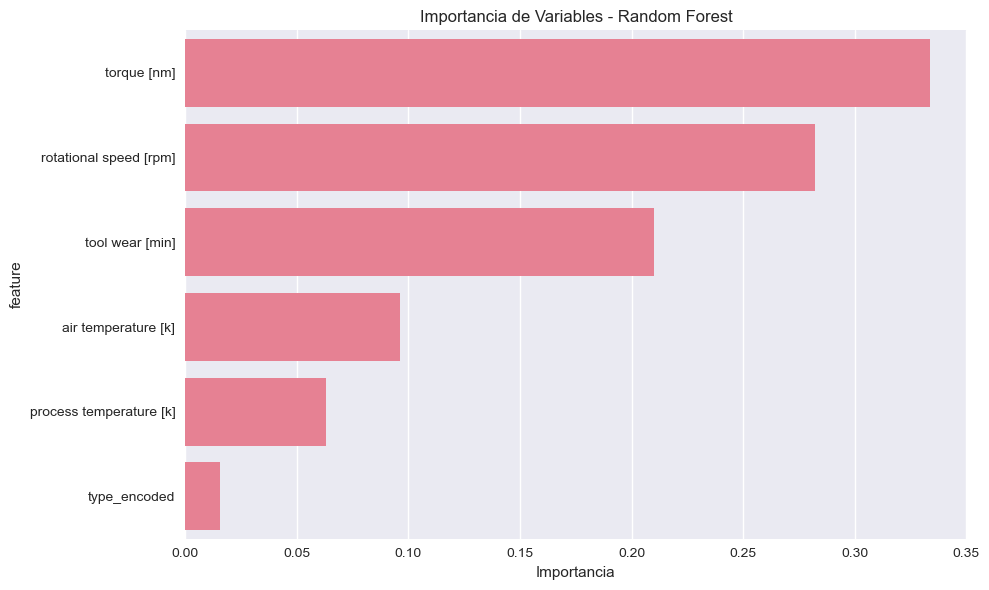

Ranking de importancia de variables:
torque [nm]: 0.3335
rotational speed [rpm]: 0.2819
tool wear [min]: 0.2099
air temperature [k]: 0.0961
process temperature [k]: 0.0631
type_encoded: 0.0155
=== GUARDANDO MODELOS Y RESULTADOS ===
✓ Modelos guardados exitosamente!

=== EJEMPLO DE PREDICCIÓN ===
Datos de prueba: [   2.   300.   311.4 1537.    35.4  120. ]
Predicción: 0, Probabilidad de falla: 0.0000
Valor real: 0
✓ Predicción correcta
=== INFORME FINAL ===

MEJOR MODELO: Random Forest
F1-Score: 0.7079
ROC-AUC: 0.9675

VARIABLES MÁS IMPORTANTES:
  torque [nm]: 0.3335
  rotational speed [rpm]: 0.2819
  tool wear [min]: 0.2099

=== RESUMEN DEL PROYECTO ===
• Total de muestras: 10000
• Fallas detectadas: 339 (3.39% del total)
• Características utilizadas: 6
• Mejor modelo: Random Forest con F1-Score de 0.7079
• Variables clave: torque [nm], rotational speed [rpm], tool wear [min]

✓ Proyecto de predicción de fallas completado exitosamente!


In [24]:
# ===== CELDA 10: ANÁLISIS DE IMPORTANCIA DE VARIABLES =====
print("=== IMPORTANCIA DE VARIABLES ===")

# Importancia de características - Random Forest
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importancia de Variables - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Ranking de importancia de variables:")
for i, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")
# ===== CELDA 11: GUARDAR MODELOS Y RESULTADOS =====
print("=== GUARDANDO MODELOS Y RESULTADOS ===")

# Guardar modelos entrenados
joblib.dump(best_rf, 'random_forest_model.pkl')
joblib.dump(best_svm, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("✓ Modelos guardados exitosamente!")

# Guardar resultados en CSV
results_df.to_csv('resultados_modelos.csv', index=False)
feature_importance.to_csv('importancia_variables.csv', index=False)

# Función de predicción para uso futuro
def predict_failure(model_type, input_data):
    """
    Función para predecir fallas con el modelo entrenado
    
    Parameters:
    model_type: 'rf' para Random Forest, 'svm' para SVM
    input_data: DataFrame con las características
    
    Returns:
    prediction: 0 (sin falla) o 1 (con falla)
    probability: probabilidad de falla
    """
    
    # Cargar modelos y preprocesadores
    scaler = joblib.load('scaler.pkl')
    le = joblib.load('label_encoder.pkl')
    
    if model_type == 'rf':
        model = joblib.load('random_forest_model.pkl')
    else:
        model = joblib.load('svm_model.pkl')
    
    # Preprocesar datos
    input_data_scaled = scaler.transform(input_data)
    
    # Predecir
    prediction = model.predict(input_data_scaled)
    probability = model.predict_proba(input_data_scaled)[:, 1]
    
    return prediction, probability

# Ejemplo de uso
print("\n=== EJEMPLO DE PREDICCIÓN ===")
sample_data = X_test.iloc[:1]  # Tomar una muestra del test
pred, prob = predict_failure('rf', sample_data)
actual_value = y_test.iloc[0]
print(f"Datos de prueba: {sample_data.values[0]}")
print(f"Predicción: {pred[0]}, Probabilidad de falla: {prob[0]:.4f}")
print(f"Valor real: {actual_value}")
print(f"✓ Predicción correcta" if pred[0] == actual_value else "✗ Predicción incorrecta")

# ===== CELDA 12: INFORME FINAL Y CONCLUSIONES =====
print("=== INFORME FINAL ===")

# Determinar el mejor modelo
best_model_row = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_name = best_model_row['Model']
best_f1 = best_model_row['F1-Score']
best_auc = best_model_row['ROC-AUC']

print(f"\nMEJOR MODELO: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
print(f"ROC-AUC: {best_auc:.4f}")

# Variables más importantes
top_3_features = feature_importance.head(3)
print(f"\nVARIABLES MÁS IMPORTANTES:")
for idx, row in top_3_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Resumen del proyecto
print(f"\n=== RESUMEN DEL PROYECTO ===")
print(f"• Total de muestras: {len(df)}")
print(f"• Fallas detectadas: {sum(y)} ({sum(y)/len(y)*100:.2f}% del total)")
print(f"• Características utilizadas: {len(features)}")
print(f"• Mejor modelo: {best_model_name} con F1-Score de {best_f1:.4f}")
print(f"• Variables clave: {', '.join(top_3_features['feature'].tolist())}")

print(f"\n✓ Proyecto de predicción de fallas completado exitosamente!")

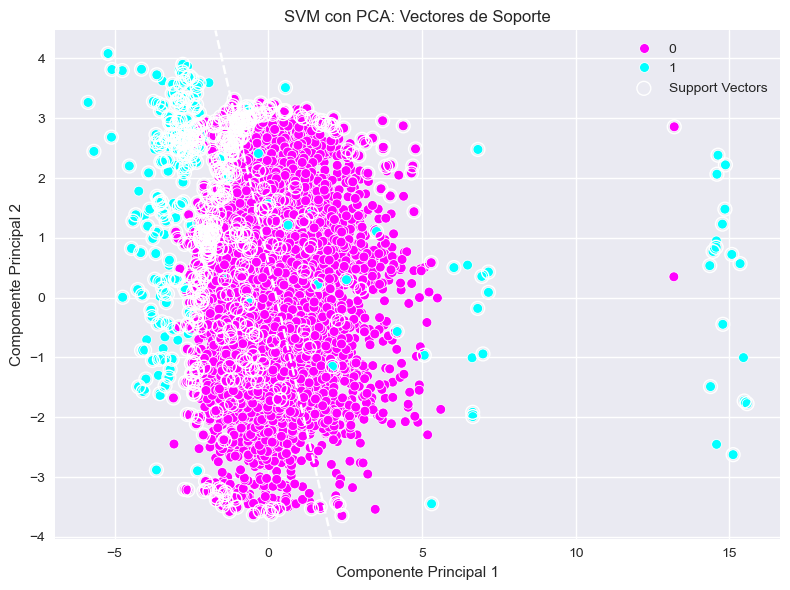

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Cargar y preparar datos
file_path = "C:\\Users\\merbe\\Desktop\\Semestre VIII\\dataset_limpio.csv"
df = pd.read_csv(file_path, sep=',')
df = df.drop(columns=['udi', 'product id', 'type'], errors='ignore')

# Separar variables
X = df.drop(columns=['machine failure'], errors='ignore')
y = df['machine failure']

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA para visualización 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Entrenar SVM
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
modelo = SVC(kernel='linear')
modelo.fit(X_train, y_train)

# Visualización
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette={0: 'magenta', 1: 'cyan'}, s=50)

# Dibujar hiperplano y vectores de soporte
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Crear malla
import numpy as np
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                     np.linspace(ylim[0], ylim[1], 500))
Z = modelo.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Dibujar líneas
ax.contour(xx, yy, Z, colors='black', levels=[0], linestyles=['-'])
ax.contour(xx, yy, Z, colors='white', levels=[-1, 1], linestyles=['--'])

# Marcar vectores de soporte
support = modelo.support_vectors_
plt.scatter(support[:, 0], support[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='white', label='Support Vectors')

plt.title("SVM con PCA: Vectores de Soporte")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.tight_layout()
plt.show()
